# Part 2 of project: Denoising MNIST via an Autoencoder

# Name: Erjian Guo, Tianyue Xing
# NetID: eg3097, tx575

In this project, we have two parts: one is denoising autoencoder on black and white pictures: MNIST, the other is denoising color pictures:cifar10.

In part 2, we used CNN to realise autoencoder on MNIST, and compared results of different combinations and parameters. We designed 6 experiments to compare denoised results from linear/non-linlear activation, numbers of convolutional layers and fully connected layers, subsampling, pooling and dropout.

The main idea of autoencoders is that it has two parts:an encoder and a decoder. Both of them use neural network. The encoder compresses original dimensions of input data. The decoder is inverse process of encoder. There are many ways to build autoencoders in Keras, such as convolutional autoencoders, sequence-to-sequence autoencoders and variational autoencoders.

Reference link:
https://chenrudan.github.io/blog/2016/04/01/dimensionalityreduction.html
https://blog.csdn.net/deephub/article/details/106991939
https://blog.csdn.net/weijifen000/article/details/89440987
https://zhuanlan.zhihu.com/p/33722444
https://www.jeremyjordan.me/autoencoders/
https://zhuanlan.zhihu.com/p/73421413
https://github.com/sdrangan/introml/blob/master/unit10_cnn/demo5_autoencoder.ipynb

Firstly, we load packages and MNIST datas. We add some Guass Noise into pictures.

In [1]:
#Load some common packages
import matplotlib.pyplot as plt
import numpy as np
import keras
import keras.backend as K
import tensorflow as tf
from keras import optimizers
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Dropout
from keras.layers.normalization import BatchNormalization


In [2]:
# Use MNIST data as experiment dataset, and rescale the input Xtr and Xts from 0 to 1
(Xtr,ytr),(Xts,yts) = tf.keras.datasets.mnist.load_data()
Xtr = np.reshape(Xtr, (len(Xtr), 28, 28, 1))
Xtr = Xtr.astype('float32') /255.
Xts = np.reshape(Xts, (len(Xts), 28, 28, 1))
Xts = Xts.astype('float32') /255.

#Add some synthetic noise to training and test data
Xtr_noisy = Xtr + 0.15 * np.random.normal(loc=0.0, scale=1.0, size=Xtr.shape) 
Xts_noisy = Xts + 0.15 * np.random.normal(loc=0.0, scale=1.0, size=Xts.shape) 

Experiment 1: construct a  auto-encoder with 2 convolution layer encoder (linear activation) and two convolution 
layer decoder (linear activation)

In [3]:
# clear the session.
K.clear_session()
# Set the input size
MN_input = Input(shape=(28,28,1))
# 2 convolution layer encoder each followed by a maxpooling layer 

X_linear = Conv2D(4, (3,3), activation='linear', padding='same')(MN_input)
X_linear = MaxPool2D((2,2), padding='same')(X_linear)
X_linear = BatchNormalization()(X_linear)

X_linear = Conv2D(8, (3,3), activation='linear', padding='same')(X_linear)
X_linear= MaxPool2D((2,2), padding='same', name='encoded_layer')(X_linear)

# 2 convolution layer decoder, each followed by a upsampling layer
X_linear = Conv2D(8, (3, 3), activation='linear', padding='same')(X_linear)
X_linear = UpSampling2D((2, 2))(X_linear)

X_linear = Conv2D(4, (3, 3), activation='linear', padding='same')(X_linear)
X_linear = UpSampling2D((2, 2))(X_linear)
X_linear = BatchNormalization()(X_linear)

MN_decode = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(X_linear)
MN_autoencoder = Model(MN_input, MN_decode)

#print the autoencoder mode summary
MN_autoencoder.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 4)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 4)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 4)         16        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         296       
_________________________________________________________________
encoded_layer (MaxPooling2D) (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)          

In [4]:
# Select the optimizer and loss function(here learning rate lr =0.01)
opt = optimizers.Adam(lr=0.01)
# COmpile the model
MN_autoencoder.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])
#
hist = MN_autoencoder.fit(Xtr_noisy, Xtr,
                epochs=10,
                batch_size=128,
                shuffle=True
                , validation_data=(Xts_noisy,Xts))

Epoch 1/10
469/469 [==============================] - 28s 59ms/step - loss: 0.0162 - accuracy: 0.8088 - val_loss: 0.0082 - val_accuracy: 0.8133
Epoch 2/10
469/469 [==============================] - 29s 61ms/step - loss: 0.0076 - accuracy: 0.8146 - val_loss: 0.0075 - val_accuracy: 0.8136
Epoch 3/10
469/469 [==============================] - 29s 62ms/step - loss: 0.0071 - accuracy: 0.8148 - val_loss: 0.0072 - val_accuracy: 0.8137
Epoch 4/10
469/469 [==============================] - 29s 62ms/step - loss: 0.0069 - accuracy: 0.8148 - val_loss: 0.0071 - val_accuracy: 0.8136
Epoch 5/10
469/469 [==============================] - 29s 62ms/step - loss: 0.0067 - accuracy: 0.8149 - val_loss: 0.0067 - val_accuracy: 0.8138
Epoch 6/10
469/469 [==============================] - 29s 62ms/step - loss: 0.0066 - accuracy: 0.8149 - val_loss: 0.0067 - val_accuracy: 0.8138
Epoch 7/10
469/469 [==============================] - 29s 61ms/step - loss: 0.0066 - accuracy: 0.8149 - val_loss: 0.0064 - val_accuracy:

In [5]:
def plot_image(Nrow, Ncol, image_size, *image_list):
    plt.figure(figsize=(2*Ncol, 2*Nrow))
    for i in range(1,Ncol+1):
        for j in range(len(image_list)):
            ax = plt.subplot(len(image_list), Ncol, i+j*Ncol)
            plt.imshow(image_list[j][i].reshape(image_size, image_size))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

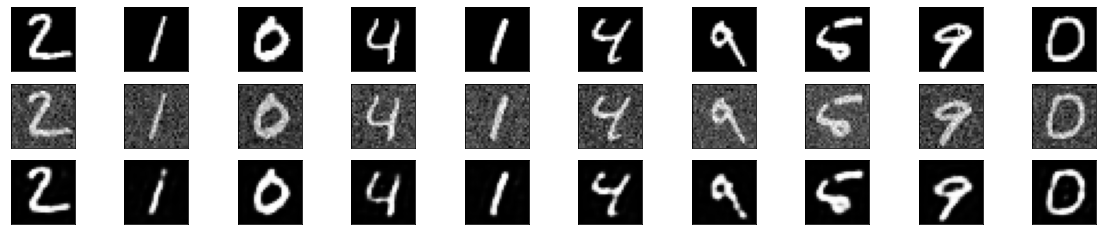

In [6]:
# Display the predict image after using autoencoder
MN_decoded_im1 = MN_autoencoder.predict(Xts_noisy)
plot_image(2, 10, 28, Xts[0:11], Xts_noisy[0:11], MN_decoded_im1[0:11])

From above pictures, we can see the denoised pictures are similar to original pictures.

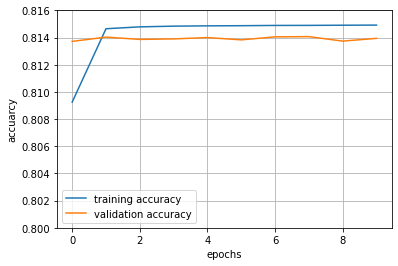

In [12]:
training_acc1 = hist.history['accuracy']
val_acc1 = hist.history['val_accuracy']

plt.plot(training_acc1)
plt.plot(val_acc1)
plt.grid()
plt.ylim(0.8,0.816)
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'validation accuracy'])

Experiment 2: construct a  auto-encoder with 2 convolution layer encoder (non-linear activation) and two convolution layer decoder (non-linear activation)

In [10]:
# clear the session.
K.clear_session()
# Set the input size
MN_input = Input(shape=(28,28,1))
#2 convolution layer encoder each followed by a maxpooling layer 
X_non = Conv2D(4, (3,3), activation='relu', padding='same')(MN_input)
X_non = MaxPool2D((2,2), padding='same')(X_non)
X_non = BatchNormalization()(X_non)

X_non = Conv2D(8, (3,3), activation='relu', padding='same')(X_non)
X_non= MaxPool2D((2,2), padding='same', name='encoded_layer')(X_non)
X_non = BatchNormalization()(X_non)

#2 convolution layer decoder, each followed by a upsampling layer
X_non = Conv2D(8, (3, 3), activation='relu', padding='same')(X_non)
X_non = UpSampling2D((2, 2))(X_non)
X_non = BatchNormalization()(X_non)

X_non = Conv2D(4, (3, 3), activation='relu', padding='same')(X_non)
X_non = UpSampling2D((2, 2))(X_non)
X_non = BatchNormalization()(X_non)

MN_decode = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(X_non)
MN_autoencoder = Model(MN_input, MN_decode)

#print the autoencoder mode summary
MN_autoencoder.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 4)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 4)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 4)         16        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         296       
_________________________________________________________________
encoded_layer (MaxPooling2D) (None, 7, 7, 8)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 8)          

In [11]:
# Select the optimizer and loss function(here learning rate lr =0.01)
opt = optimizers.Adam(lr=0.01)
# COmpile the model
MN_autoencoder.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])
#fit the model
hist = MN_autoencoder.fit(Xtr_noisy, Xtr,
                epochs=10,
                batch_size=128,
                shuffle=True
                , validation_data=(Xts_noisy,Xts))

Epoch 1/10
469/469 [==============================] - 28s 61ms/step - loss: 0.0168 - accuracy: 0.8092 - val_loss: 0.0075 - val_accuracy: 0.8137
Epoch 2/10
469/469 [==============================] - 29s 63ms/step - loss: 0.0071 - accuracy: 0.8146 - val_loss: 0.0072 - val_accuracy: 0.8140
Epoch 3/10
469/469 [==============================] - 30s 64ms/step - loss: 0.0065 - accuracy: 0.8148 - val_loss: 0.0062 - val_accuracy: 0.8139
Epoch 4/10
469/469 [==============================] - 31s 66ms/step - loss: 0.0063 - accuracy: 0.8148 - val_loss: 0.0059 - val_accuracy: 0.8139
Epoch 5/10
469/469 [==============================] - 30s 65ms/step - loss: 0.0062 - accuracy: 0.8149 - val_loss: 0.0063 - val_accuracy: 0.8140
Epoch 6/10
469/469 [==============================] - 30s 64ms/step - loss: 0.0061 - accuracy: 0.8149 - val_loss: 0.0060 - val_accuracy: 0.8138
Epoch 7/10
469/469 [==============================] - 30s 64ms/step - loss: 0.0060 - accuracy: 0.8149 - val_loss: 0.0058 - val_accuracy:

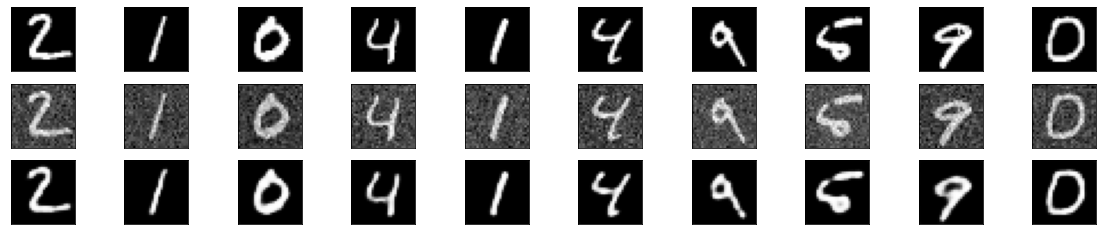

In [13]:
# Display predict images after using autoencoder
MN_decoded_im2 = MN_autoencoder.predict(Xts_noisy)
plot_image(2, 10, 28, Xts[0:11], Xts_noisy[0:11], MN_decoded_im2[0:11])

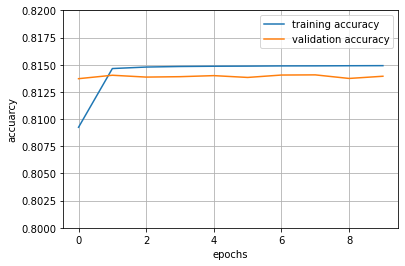

In [15]:
#plot the accuracy 
training_acc2 = hist.history['accuracy']
val_acc2 = hist.history['val_accuracy']

plt.plot(training_acc2)
plt.plot(val_acc2)
plt.grid()
plt.ylim(0.8,0.82)
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'validation accuracy'])

From above pictures, we can see the results of linear activations are better than results of nonlinear activations.

Experiment 3: construct one convolution layer followed by one denselayer encoder and one convolution layer followed by one denselayer decoder

In [16]:
# clear the session.
K.clear_session()
# Set the input size
MN_input = Input(shape=(28,28,1))

#one convolution layer followed by one denselayer encoder
X_mix = Conv2D(4, (3,3), activation='linear', padding='same')(MN_input)
X_mix = MaxPool2D((2,2), padding='same')(X_mix)
X_mix = BatchNormalization()(X_mix)

X_mix = Dense(8, activation='relu')(X_mix)
X_mix= MaxPool2D((2,2), padding='same', name='encoded_layer')(X_mix)
X_mix = BatchNormalization()(X_mix)
X_mix = Dropout(0.25)(X_mix)

# one convolution layer followed by one denselayer decoder
X_mix = Dense(8, activation='relu')(X_mix)
X_mix = UpSampling2D((2, 2))(X_mix)
X_mix = BatchNormalization()(X_mix)
X_mix = Dropout(0.25)(X_mix)
X_mix = Conv2D(4, (3, 3), activation='linear', padding='same')(X_mix)
X_mix = UpSampling2D((2, 2))(X_mix)
X_mix = BatchNormalization()(X_mix)

MN_decode = Dense(1, activation='sigmoid')(X_mix)
MN_autoencoder = Model(MN_input, MN_decode)

#print the autoencoder mode summary
MN_autoencoder.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 4)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 4)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 4)         16        
_________________________________________________________________
dense (Dense)                (None, 14, 14, 8)         40        
_________________________________________________________________
encoded_layer (MaxPooling2D) (None, 7, 7, 8)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 8)          

In [17]:
# Select the optimizer and loss function(here learning rate lr =0.01)
opt = optimizers.Adam(lr=0.01)
# COmpile the model
MN_autoencoder.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])
#
hist = MN_autoencoder.fit(Xtr_noisy, Xtr,
                epochs=10,
                batch_size=128,
                shuffle=True
                , validation_data=(Xts_noisy,Xts))

Epoch 1/10
469/469 [==============================] - 19s 40ms/step - loss: 0.0392 - accuracy: 0.7965 - val_loss: 0.0273 - val_accuracy: 0.8102
Epoch 2/10
469/469 [==============================] - 19s 40ms/step - loss: 0.0289 - accuracy: 0.8050 - val_loss: 0.0235 - val_accuracy: 0.8068
Epoch 3/10
469/469 [==============================] - 19s 41ms/step - loss: 0.0283 - accuracy: 0.8051 - val_loss: 0.0231 - val_accuracy: 0.8075
Epoch 4/10
469/469 [==============================] - 20s 42ms/step - loss: 0.0283 - accuracy: 0.8050 - val_loss: 0.0231 - val_accuracy: 0.8065
Epoch 5/10
469/469 [==============================] - 20s 42ms/step - loss: 0.0282 - accuracy: 0.8051 - val_loss: 0.0231 - val_accuracy: 0.8069
Epoch 6/10
469/469 [==============================] - 20s 43ms/step - loss: 0.0283 - accuracy: 0.8050 - val_loss: 0.0230 - val_accuracy: 0.8068
Epoch 7/10
469/469 [==============================] - 20s 43ms/step - loss: 0.0283 - accuracy: 0.8051 - val_loss: 0.0231 - val_accuracy:

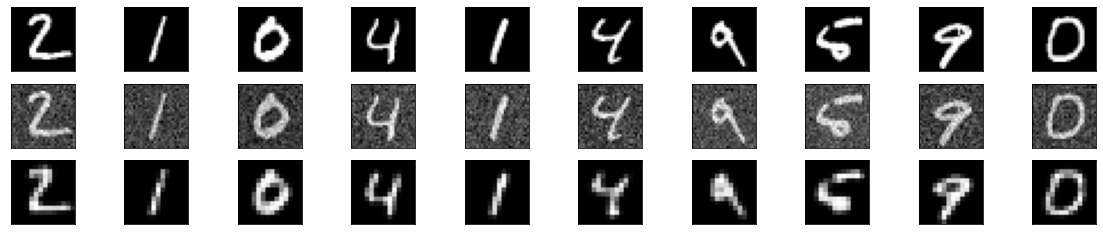

In [18]:
# Display the predict image after using autoencoder
MN_decoded_im3 = MN_autoencoder.predict(Xts_noisy)
plot_image(2, 10, 28, Xts[0:11], Xts_noisy[0:11], MN_decoded_im3[0:11])

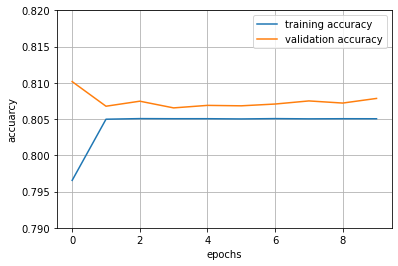

In [21]:
training_acc3 = hist.history['accuracy']
val_acc3 = hist.history['val_accuracy']

plt.plot(training_acc3)
plt.plot(val_acc3)
plt.grid()
plt.ylim(0.79,0.82)
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'validation accuracy'])

Because we only have on convolutional layers, the accuracy is less than before.

Experiment 4: no use maxpool, upsampling, batchnomalization and dropout layers

In [22]:
# clear the session.
K.clear_session()
# Set the input size
MN_input = Input(shape=(28,28,1))

#one convolution layer followed by one dense layer encoder
X_no = Conv2D(4, (3,3), activation='linear', padding='same')(MN_input)
X_no = Dense(8, activation='relu')(X_no)

# one convolution layer followed by one dense layer decoder
X_no = Dense(8, activation='relu')(X_no)
X_no = Conv2D(4, (3, 3), activation='linear', padding='same')(X_no)

MN_decode = Dense(1, activation='sigmoid')(X_no)
MN_autoencoder = Model(MN_input, MN_decode)

#print the autoencoder mode summary
MN_autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 4)         40        
_________________________________________________________________
dense (Dense)                (None, 28, 28, 8)         40        
_________________________________________________________________
dense_1 (Dense)              (None, 28, 28, 8)         72        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 4)         292       
_________________________________________________________________
dense_2 (Dense)              (None, 28, 28, 1)         5         
Total params: 449
Trainable params: 449
Non-trainable params: 0
________________________________________________________

In [23]:
# Select the optimizer and loss function(here learning rate lr =0.01)
opt = optimizers.Adam(lr=0.01)
# COmpile the model
MN_autoencoder.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])
#
hist = MN_autoencoder.fit(Xtr_noisy, Xtr,
                epochs=10,
                batch_size=128,
                shuffle=True
                , validation_data=(Xts_noisy,Xts))

Epoch 1/10
469/469 [==============================] - 15s 33ms/step - loss: 0.0063 - accuracy: 0.8149 - val_loss: 0.0021 - val_accuracy: 0.8145
Epoch 2/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0020 - accuracy: 0.8155 - val_loss: 0.0019 - val_accuracy: 0.8145
Epoch 3/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0019 - accuracy: 0.8155 - val_loss: 0.0019 - val_accuracy: 0.8145
Epoch 4/10
469/469 [==============================] - 16s 35ms/step - loss: 0.0019 - accuracy: 0.8155 - val_loss: 0.0018 - val_accuracy: 0.8145
Epoch 5/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0019 - accuracy: 0.8155 - val_loss: 0.0018 - val_accuracy: 0.8145
Epoch 6/10
469/469 [==============================] - 16s 35ms/step - loss: 0.0018 - accuracy: 0.8155 - val_loss: 0.0018 - val_accuracy: 0.8145
Epoch 7/10
469/469 [==============================] - 16s 35ms/step - loss: 0.0018 - accuracy: 0.8155 - val_loss: 0.0018 - val_accuracy:

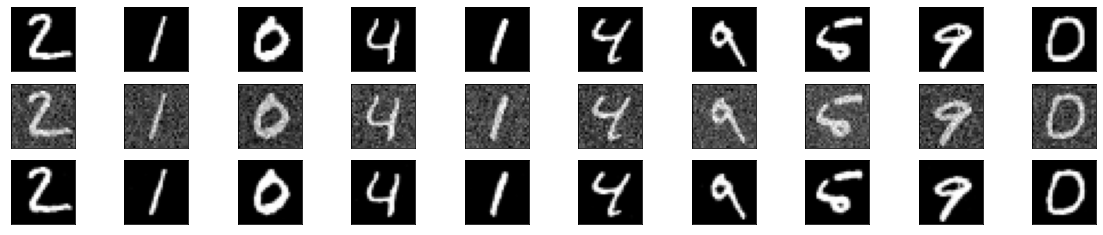

In [35]:
# Display the predict image after using autoencoder
MN_decoded_im4 = MN_autoencoder.predict(Xts_noisy)
plot_image(2, 10, 28, Xts[0:11], Xts_noisy[0:11], MN_decoded_im4[0:11])

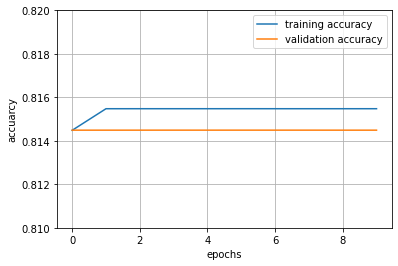

In [36]:
training_acc4 = hist.history['accuracy']
val_acc4 = hist.history['val_accuracy']

plt.plot(training_acc4)
plt.plot(val_acc4)
plt.grid()
plt.ylim(0.81,0.82)
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'validation accuracy'])

Experiment 5:increase the number of layers in encoder and decoder

In [27]:
# clear the session.
K.clear_session()
# Set the input size
MN_input = Input(shape=(28,28,1))

#2 convolution layers followed by 2 dense layers encoder
X_inc = Conv2D(4, (3,3), activation='linear', padding='same')(MN_input)
X_inc = Conv2D(8, (3,3), activation='linear', padding='same')(X_inc)
X_inc = Conv2D(16, (3,3), activation='linear', padding='same')(X_inc)
X_inc = Dense(8, activation='relu')(X_inc)
X_inc = Dense(4, activation='relu')(X_inc)

# 2 convolution layers followed by 2 dense layers decoder
X_inc = Dense(4, activation='relu')(X_inc)
X_inc = Dense(8, activation='relu')(X_inc)
X_inc = Conv2D(16, (3,3), activation='linear', padding='same')(X_inc)
X_inc = Conv2D(8, (3, 3), activation='linear', padding='same')(X_inc)
X_inc = Conv2D(4, (3, 3), activation='linear', padding='same')(X_inc)

MN_decode = Dense(1, activation='sigmoid')(X_inc)
MN_autoencoder = Model(MN_input, MN_decode)

#print the autoencoder mode summary
MN_autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 4)         40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         296       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        1168      
_________________________________________________________________
dense (Dense)                (None, 28, 28, 8)         136       
_________________________________________________________________
dense_1 (Dense)              (None, 28, 28, 4)         36        
_________________________________________________________________
dense_2 (Dense)              (None, 28, 28, 4)        

In [28]:
# Select the optimizer and loss function(here learning rate lr =0.01)
opt = optimizers.Adam(lr=0.01)
# COmpile the model
MN_autoencoder.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])
#
hist = MN_autoencoder.fit(Xtr_noisy, Xtr,
                epochs=10,
                batch_size=128,
                shuffle=True
                , validation_data=(Xts_noisy,Xts))

Epoch 1/10
469/469 [==============================] - 52s 111ms/step - loss: 0.0057 - accuracy: 0.8145 - val_loss: 0.0021 - val_accuracy: 0.8145
Epoch 2/10
469/469 [==============================] - 53s 112ms/step - loss: 0.0018 - accuracy: 0.8155 - val_loss: 0.0018 - val_accuracy: 0.8145
Epoch 3/10
469/469 [==============================] - 53s 113ms/step - loss: 0.0017 - accuracy: 0.8155 - val_loss: 0.0017 - val_accuracy: 0.8145
Epoch 4/10
469/469 [==============================] - 53s 114ms/step - loss: 0.0017 - accuracy: 0.8155 - val_loss: 0.0017 - val_accuracy: 0.8145
Epoch 5/10
469/469 [==============================] - 53s 113ms/step - loss: 0.0017 - accuracy: 0.8155 - val_loss: 0.0017 - val_accuracy: 0.8145
Epoch 6/10
469/469 [==============================] - 53s 113ms/step - loss: 0.0017 - accuracy: 0.8155 - val_loss: 0.0017 - val_accuracy: 0.8145
Epoch 7/10
469/469 [==============================] - 53s 114ms/step - loss: 0.0017 - accuracy: 0.8155 - val_loss: 0.0018 - val_ac

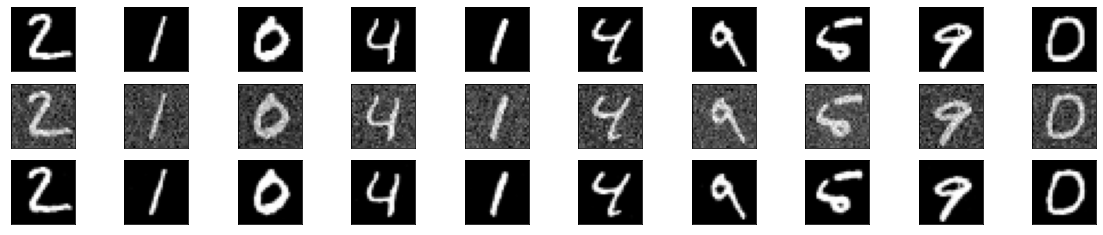

In [29]:
# Display the predict image after using autoencoder
MN_decoded_im5 = MN_autoencoder.predict(Xts_noisy)
plot_image(2, 10, 28, Xts[0:11], Xts_noisy[0:11], MN_decoded_im5[0:11])

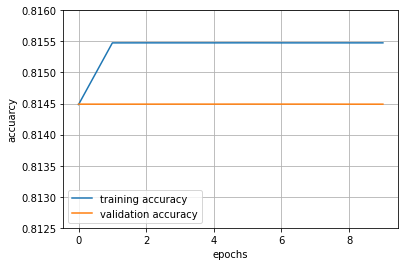

In [33]:
training_acc5 = hist.history['accuracy']
val_acc5 = hist.history['val_accuracy']

plt.plot(training_acc5)
plt.plot(val_acc5)
plt.grid()
plt.ylim(0.8125,0.816)
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'validation accuracy'])

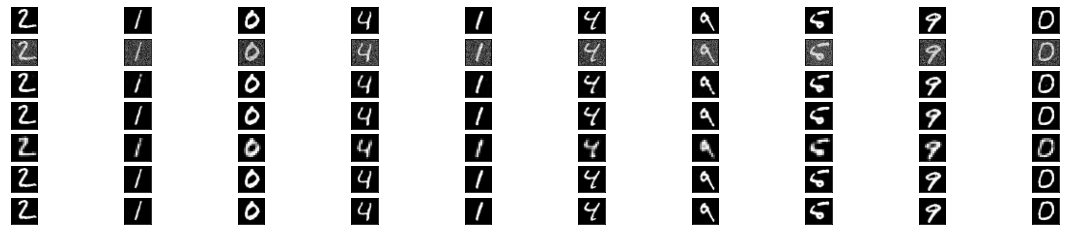

In [37]:
# plot the predict images of all experiments 
plot_image(2, 10, 28, Xts[0:11], Xts_noisy[0:11], MN_decoded_im1[0:11],MN_decoded_im2[0:11],MN_decoded_im3[0:11],MN_decoded_im4[0:11],MN_decoded_im5[0:11])

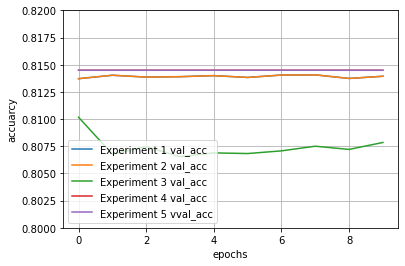

In [39]:
# plot the accuracy of all experiments 
plt.plot(val_acc1)
plt.plot(val_acc2)
plt.plot(val_acc3)
plt.plot(val_acc4)
plt.plot(val_acc5)
plt.grid()
plt.ylim(0.8,0.82)
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['Experiment 1 val_acc ','Experiment 2 val_acc ','Experiment 3 val_acc ','Experiment 4 val_acc ','Experiment 5 vval_acc'])

Exeriment 6:Choose the appropriate learning rate

In [41]:
rates = [0.01,0.001,0.0001]
batch_size = 128
loss_hist = []

# TODO
for lr in rates:
        
    # Clear the session
    K.clear_session()

   # Set the input size
    MN_input = Input(shape=(28,28,1))

    #one convolution layer followed by one dense layer encoder
    X_non = Conv2D(16, (3,3), activation='linear', padding='same')(MN_input)
    X_non = Dense(16, activation='relu')(X_non)

    # one convolution layer followed by one dense layer decoder
    X_non = Dense(16, activation='relu')(X_non)
    X_non = Conv2D(16, (3, 3), activation='linear', padding='same')(X_non)

    MN_decode = Dense(1, activation='sigmoid')(X_non)
    MN_autoencoder = Model(MN_input, MN_decode)
    
    # Select the optimizer and loss function(here learning rate lr =0.01)
    opt = optimizers.Adam(lr=lr)
    # COmpile the model
    MN_autoencoder.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])
 
        
    # Fit the model    
    hist = MN_autoencoder.fit(Xtr_noisy, Xtr,
                epochs=10,
                batch_size=batch_size,
                shuffle=True
                , validation_data=(Xts_noisy,Xts))    
    
    # Save the loss history
    loss_hist.append( hist.history['loss'])
    
    # Print the final accuracy
    val_acc = hist.history['val_accuracy'][-1]
    print("lr=%12.4e test accuracy=%f" % (lr, val_acc))

Epoch 1/10
469/469 [==============================] - 22s 47ms/step - loss: 0.0043 - accuracy: 0.8144 - val_loss: 0.0020 - val_accuracy: 0.8145
Epoch 2/10
469/469 [==============================] - 22s 48ms/step - loss: 0.0019 - accuracy: 0.8155 - val_loss: 0.0018 - val_accuracy: 0.8145
Epoch 3/10
469/469 [==============================] - 23s 49ms/step - loss: 0.0018 - accuracy: 0.8155 - val_loss: 0.0017 - val_accuracy: 0.8145
Epoch 4/10
469/469 [==============================] - 23s 50ms/step - loss: 0.0018 - accuracy: 0.8155 - val_loss: 0.0017 - val_accuracy: 0.8145
Epoch 5/10
469/469 [==============================] - 23s 50ms/step - loss: 0.0017 - accuracy: 0.8155 - val_loss: 0.0017 - val_accuracy: 0.8145
Epoch 6/10
469/469 [==============================] - 23s 49ms/step - loss: 0.0017 - accuracy: 0.8155 - val_loss: 0.0017 - val_accuracy: 0.8145
Epoch 7/10
469/469 [==============================] - 23s 49ms/step - loss: 0.0017 - accuracy: 0.8155 - val_loss: 0.0018 - val_accuracy:

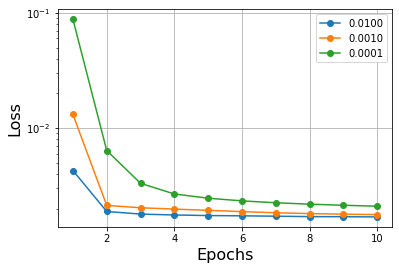

In [42]:
ntest = len(loss_hist)
ntr = 10
batch_size=128
for it, loss in enumerate(loss_hist):
    
    nepochs = len(loss)
    epochs = np.arange(1,nepochs+1)
    plt.semilogy(epochs, loss, 'o-')

    rate_str = ['{0:5.4f}'.format(lr) for lr in rates]

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(rate_str,loc='upper right')
plt.grid()

Conclution: The denoised results of non-linear activattion are better than results of linear. More convolutional layers has better performance. Pooling and dropout can reduce dimensions but less accuracy.